In [1]:
from functions import *


import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
from skimage.feature import blob_log
from apsg import *
import pandas as pd


microm2m = 1.0E-6
m2microm = 1.0E6
plt.rcParams["figure.figsize"] = (10,10)

In [2]:
flight = 5.0  # sample-sensor distance
area = (0, 1000*microm2m, 0, 1000*microm2m)
shape = (1000,1000)
z = -flight*microm2m

f = np.matrix(regular(area, shape, z))
X = np.array(f[0])
Y = np.array(f[1])
Z = np.array(f[2])

cm = 10**(-7) # H/m  == T·m/A


# generates x sourcers
sourcers = 10
D = [-140,  0, -70, 125]
I = [-30 , 62, -50,  22]
Q = [20000, 20000, 20000, 20000]
R = np.array([0.5, 0.45, 0.40, 0.42])*microm2m

Xc = np.array([250,  500, 750,  200])*microm2m
Yc = np.array([250,  500, 750,  800])*microm2m
Zc = np.array([8.5, 10.0, 5.3, 7.75])*microm2m



m = cartesian_components(D, I, Q, R)
M = sensibility_matrix(X, Y, Z, Xc, Yc, Zc)


In [3]:
# data vector direct model
d = np.matmul(M, m)

#apply noise
#error = 0.05   # % for the 'max amplitude method'
error = 5.0e-9 # nT for the 'fixed method'

d = noise(d, error=error, method='fixed')

# Reshape data vector for the map plot
d_= np.reshape(d, shape)

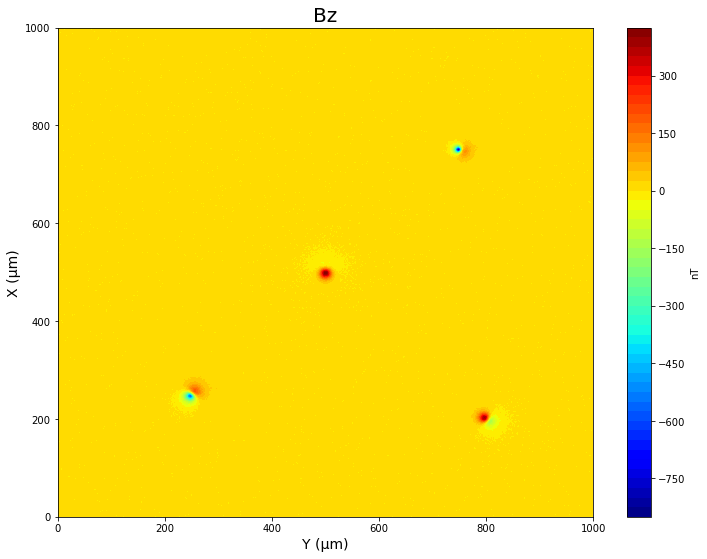

In [4]:
xs = np.linspace(area[0], area[1], shape[0])
ys = np.linspace(area[2], area[3], shape[1])

x_plot = np.reshape(Y,(np.size(xs),np.size(ys)))*m2microm
y_plot = np.reshape(X,(np.size(xs),np.size(ys)))*m2microm

# plot do mapa de dados do modelo direto

plt.figure(figsize=(12,9))
plt.contourf(x_plot, y_plot, d_*10**9, levels=50, cmap='jet')
plt.colorbar(label='nT')

plt.title('Bz', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.show()

In [5]:
X_ = np.reshape(X, shape)
Y_ = np.reshape(Y, shape)
Z_ = np.reshape(Z, shape)


# calculating derivatives using Fast Fourier Transform (FFT)

wx, wy, wz = wave_numbers(d_, X_, Y_)

ddx = x_derivative_fft(d_, wx, order=1)
ddy = y_derivative_fft(d_, wy, order=1)
ddz = z_derivative_fft(d_, wz, order=1)

# calculating derivatives (x and y) using Finite Differences (FD)
d_X, d_Y = (derivative_fd(d_, X_,Y_, order=1))


Text(0, 0.5, 'X (µm)')

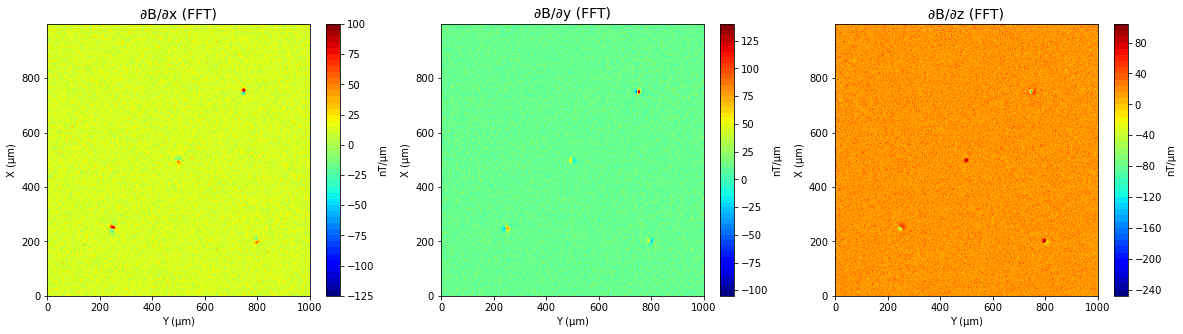

In [6]:
# plot FFT derivatives
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(20,5))

ax1_plot  = ax1.contourf(x_plot[::2], y_plot[::2], ddx[::2]*10**3, levels=50, cmap='jet')
plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
ax1.set_title('∂B/∂x (FFT)', fontsize=14)
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

ax2_plot  = ax2.contourf(x_plot[::2], y_plot[::2], ddy[::2]*10**3, levels=50, cmap='jet')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title('∂B/∂y (FFT)', fontsize=14)
ax2.set_xlabel('Y (µm)', fontsize=10)
ax2.set_ylabel('X (µm)', fontsize=10)

ax3_plot  = ax3.contourf(x_plot[::2], y_plot[::2], ddz[::2]*10**3, levels=50, cmap='jet')
plt.colorbar(ax3_plot, ax=ax3, label='nT/µm')
ax3.set_title('∂B/∂z (FFT)', fontsize=14)
ax3.set_xlabel('Y (µm)', fontsize=10)
ax3.set_ylabel('X (µm)', fontsize=10)

Text(0, 0.5, 'X (µm)')

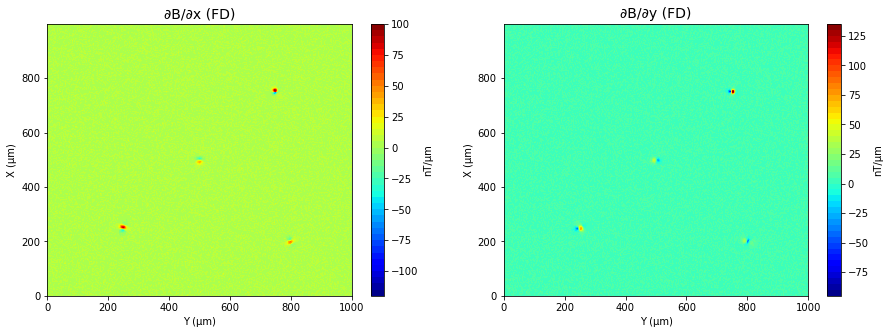

In [7]:
# plot FD derivatives
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(15,5))

ax1_plot  = ax1.contourf(x_plot[::2], y_plot[::2], d_X[::2]*10**3, levels=50, cmap='jet')
plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
ax1.set_title('∂B/∂x (FD)', fontsize=14)
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

ax2_plot = ax2.contourf(x_plot[::2], y_plot[::2], d_Y[::2]*10**3, levels=50, cmap='jet')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title('∂B/∂y (FD)', fontsize=14)
ax2.set_xlabel('Y (µm)', fontsize=10)
ax2.set_ylabel('X (µm)', fontsize=10)

In [8]:
# Calculating the horizontal gradient (GH) using FFT e FD

Horiz_Grad_FD = Horiz_Grad(d_Y , d_X)
Horiz_Grad_FFT = Horiz_Grad(ddy, ddx)

Text(0, 0.5, 'X (µm)')

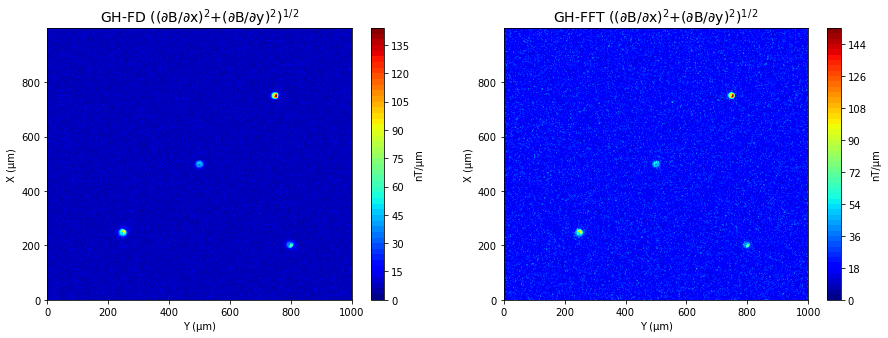

In [9]:
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(15,5))

# plot FD horizontal gradient 
ax1_plot  = ax1.contourf(x_plot[::2], y_plot[::2], Horiz_Grad_FD[::2]*10**3, levels=50, cmap='jet')
plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
ax1.set_title('GH-FD'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=14)
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

# plot FFT horizontal gradient 
ax2_plot = ax2.contourf(x_plot[::2], y_plot[::2], Horiz_Grad_FFT[::2]*10**3, levels=50, cmap='jet')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title('GH-FFT'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=14)
ax2.set_xlabel('Y (µm)', fontsize=10)
ax2.set_ylabel('X (µm)', fontsize=10)

In [10]:
# upward_continuation filtering --> to remove high frequency noise
height = 5.0      # delta_z upward continuation
delta_z = -height*microm2m
upward = upward_continuation(d_, delta_z, wz)


# upward_continuation --> used later to calculate the Z derivative by FD
delta_z1 = -(height-0.1)*microm2m
upward1 = upward_continuation(d_, delta_z1, wz)

delta_z2 = -(height+0.1)*microm2m
upward2 = upward_continuation(d_, delta_z2, wz)

Text(0, 0.5, 'X (µm)')

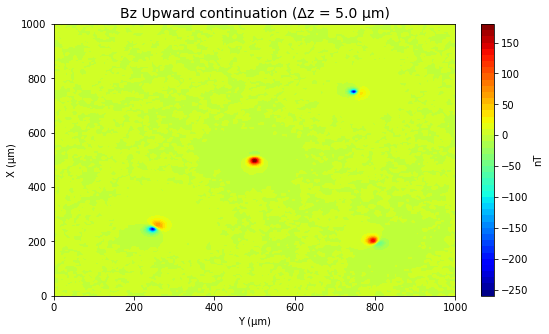

In [11]:
# upward continuation plot

plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, (upward)*10**9, levels=50, cmap='jet')
plt.colorbar(label='nT')

plt.title('Bz Upward continuation (Δz = %s µm)'%height, fontsize=14)
plt.xlabel('Y (µm)', fontsize=10)
plt.ylabel('X (µm)', fontsize=10)



In [12]:
# New derivatives by FFT
ddy = y_derivative_fft(upward, wy)
ddx = x_derivative_fft(upward, wx)
ddz = z_derivative_fft(upward, wz)


Text(0, 0.5, 'X (µm)')

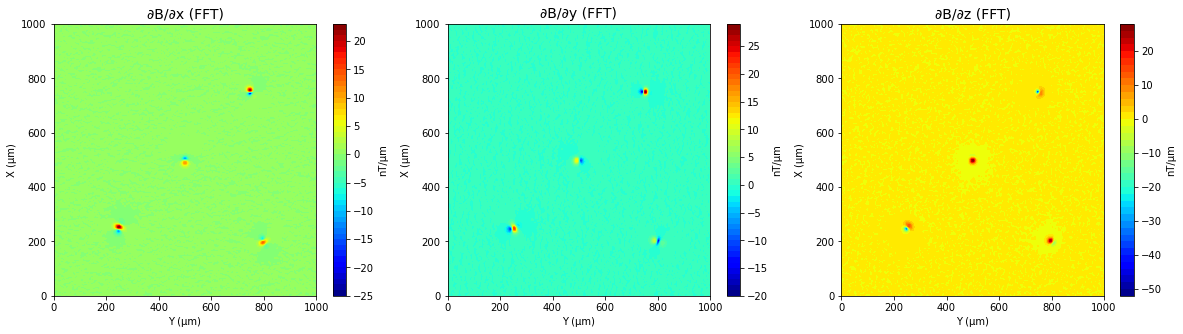

In [13]:
# Plot derivatives by FFT (after upward continuation)

fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(20,5))

ax1_plot  = ax1.contourf(x_plot, y_plot, ddx*10**3, levels=50, cmap='jet')
plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
ax1.set_title('∂B/∂x (FFT)', fontsize=14)
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

ax2_plot  = ax2.contourf(x_plot, y_plot, ddy*10**3, levels=50, cmap='jet')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title('∂B/∂y (FFT)', fontsize=14)
ax2.set_xlabel('Y (µm)', fontsize=10)
ax2.set_ylabel('X (µm)', fontsize=10)

ax3_plot  = ax3.contourf(x_plot, y_plot, ddz*10**3, levels=50, cmap='jet')
plt.colorbar(ax3_plot, ax=ax3, label='nT/µm')
ax3.set_title('∂B/∂z (FFT)', fontsize=14)
ax3.set_xlabel('Y (µm)', fontsize=10)
ax3.set_ylabel('X (µm)', fontsize=10)


In [14]:
# New derivatives by FD
d_X, d_Y = (derivative_fd(upward, X_,Y_))
d_Z = z_derivative_fd(upward1, upward2, delta_z1, delta_z2)

Text(0, 0.5, 'X (µm)')

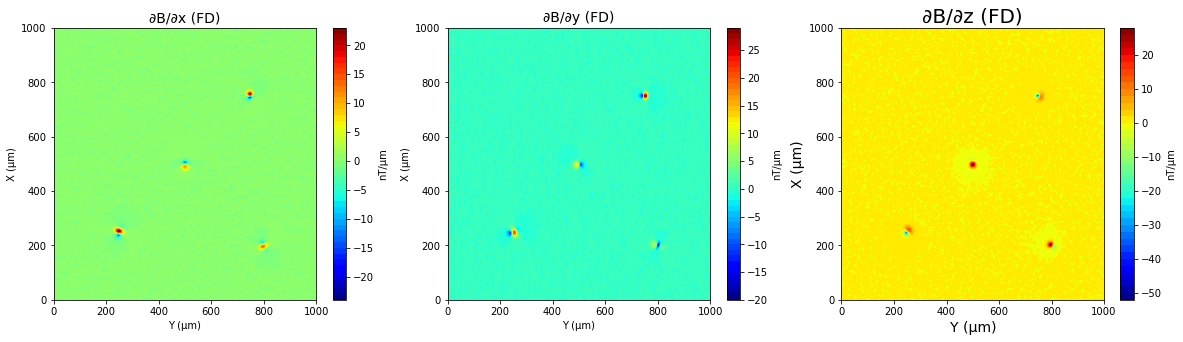

In [15]:
# Plot derivatives by FD (after upward continuation)
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(20,5))

ax1_plot  = ax1.contourf(x_plot, y_plot, d_X*10**3, levels=50, cmap='jet')
plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
ax1.set_title('∂B/∂x (FD)', fontsize=14)
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

ax2_plot = ax2.contourf(x_plot, y_plot, d_Y*10**3, levels=50, cmap='jet')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title('∂B/∂y (FD)', fontsize=14)
ax2.set_xlabel('Y (µm)', fontsize=10)
ax2.set_ylabel('X (µm)', fontsize=10)

ax3_plot = ax3.contourf(x_plot, y_plot, d_Z*10**3, levels=50, cmap='jet')
plt.colorbar(ax3_plot, ax=ax3, label='nT/µm')
ax3.set_title('∂B/∂z (FD)', fontsize=20)
ax3.set_xlabel('Y (µm)', fontsize=14)
ax3.set_ylabel('X (µm)', fontsize=14)

In [16]:
# total gradient data
Total_Grad_FD = Total_Grad(d_Y , d_X, d_Z)
Total_Grad_FFT = Total_Grad(ddy, ddx, ddz)

Text(0, 0.5, 'X (µm)')

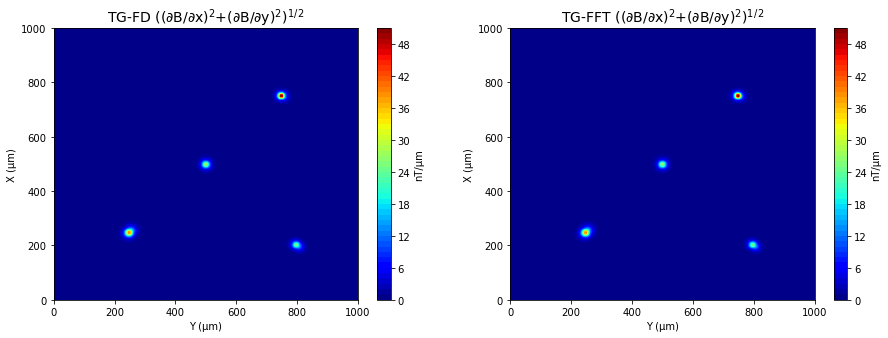

In [17]:
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(15,5))

# plot FD total gradient 
ax1_plot  = ax1.contourf(x_plot, y_plot, Total_Grad_FD*10**3, levels=50, cmap='jet')
plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
ax1.set_title('TG-FD'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=14)
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

# plot FFT total gradient 
ax2_plot = ax2.contourf(x_plot, y_plot, Total_Grad_FFT*10**3, levels=50, cmap='jet')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title('TG-FFT'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=14)
ax2.set_xlabel('Y (µm)', fontsize=10)
ax2.set_ylabel('X (µm)', fontsize=10)

# Euler solver

Text(0, 0.5, 'Count')

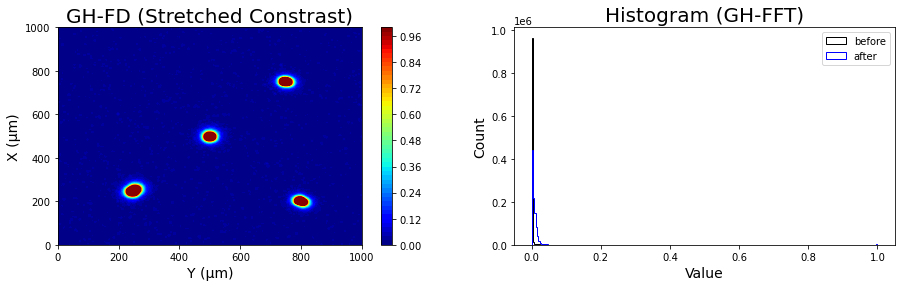

In [18]:
import skimage
import scipy.signal as signal

image =  Total_Grad_FD/Total_Grad_FD.max()

perc_min, perc_max = np.percentile(image, (20.5,99.5))
stretched_image = skimage.exposure.rescale_intensity(image, in_range=(perc_min, perc_max))


fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(15,4))

ax1_plot = ax1.contourf(x_plot, y_plot, stretched_image, levels=50, cmap='jet')
ax1.set_title('GH-FD (Stretched Constrast)', fontsize=20)
ax1.set_xlabel('Y (µm)', fontsize=14)
ax1.set_ylabel('X (µm)', fontsize=14)

plt.colorbar(ax1_plot, ax=ax1)

ax2.hist(image.ravel(), bins=256, histtype='step', color='k', label='before');
ax2.hist(stretched_image.ravel(), bins=256, histtype='step', color='b', label='after');
ax2.legend()
ax2.set_title('Histogram (GH-FFT)', fontsize=20)
ax2.set_xlabel('Value', fontsize=14)
ax2.set_ylabel('Count', fontsize=14)


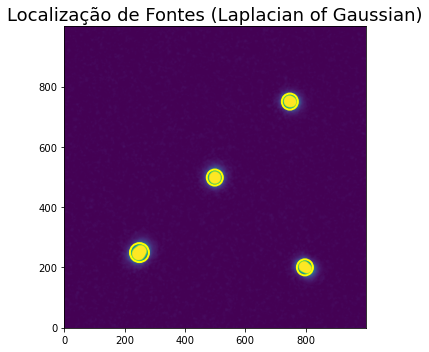

(4, 4)


()

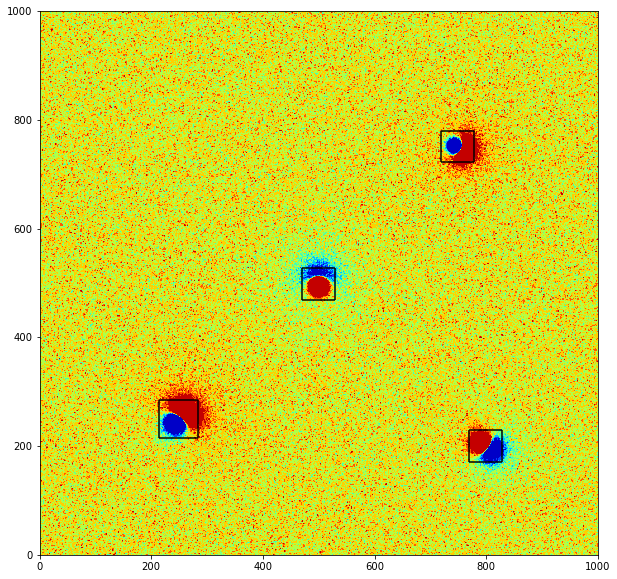

In [19]:
circles_FD, euler_windows_FD = sources_finder(stretched_image, threshold=0.5, min_sigma=5, max_sigma=30, num_sigma=30, overlap=1.0, radius_increment=0.1)
print(np.shape(euler_windows_FD))

Xc_FD, Yc_FD, Zc_FD, filtered_euler_windows_FD = solve_euler_windows(euler_windows_FD, X_, Y_, Z_, upward, d_X, d_Y, d_Z, delta_z, structural_index = 3.0)

import skimage
perc_min, perc_max = np.percentile(d_, (0.5,99.5))
view = skimage.exposure.rescale_intensity(d_, in_range=(perc_min, perc_max))
euler_windows_view(X_, Y_, Z_, view, filtered_euler_windows_FD, show_windows=False, color='k')


Euler Solutions:
    Xc (µm)   Yc (µm)  Zc (µm)
0  749.9888  749.9856   5.3610
1  250.0091  250.0024   8.5257
2  200.0165  799.9753   7.7748
3  499.9994  500.0335  10.0108

Original Positions:
   Xc (µm)  Yc (µm)  Zc (µm)
0    250.0    250.0     8.50
1    500.0    500.0    10.00
2    750.0    750.0     5.30
3    200.0    800.0     7.75



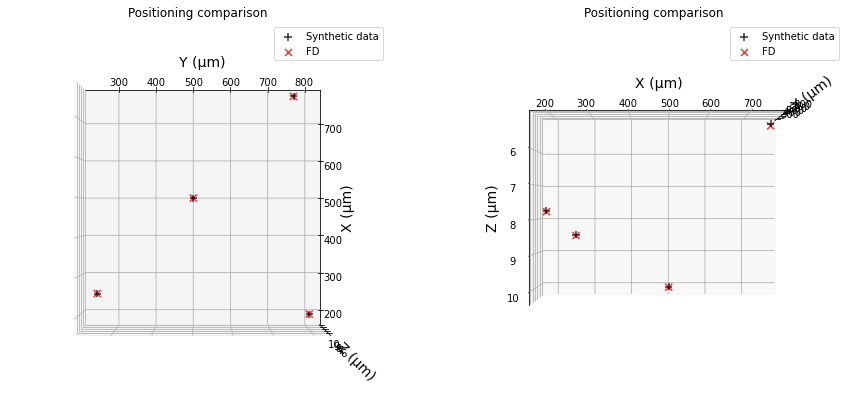

In [20]:
import pandas as pd
print('Euler Solutions:')
df1 = pd.DataFrame(data={'Xc (µm)': (np.round(Xc_FD*m2microm, decimals=4)),
                        'Yc (µm)': (np.round(Yc_FD*m2microm, decimals=4)),
                        'Zc (µm)': (np.round(Zc_FD*m2microm, decimals=4))
                       })

print(df1)
print()

print('Original Positions:')
df2 = pd.DataFrame(data={
                        'Xc (µm)': (np.round(Xc*m2microm, decimals=4)),
                        'Yc (µm)': (np.round(Yc*m2microm, decimals=4)),
                        'Zc (µm)': (np.round(Zc*m2microm, decimals=4))
                       })

print(df2)
print()

from mpl_toolkits.mplot3d import axes3d


fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.scatter(Yc*m2microm, Xc*m2microm, Zc*m2microm, alpha=0.8, color='k', marker='+', s=50, label='Synthetic data')
ax1.scatter(Yc_FD*m2microm, Xc_FD*m2microm, Zc_FD*m2microm, alpha=0.8, color='r', marker='x', s=50, label='FD')

ax1.set_title('Positioning comparison')
ax1.legend(loc='best')
ax1.invert_zaxis()

ax1.set_xlabel('Y (µm)', fontsize=14)
ax1.set_ylabel('X (µm)', fontsize=14)
ax1.set_zlabel('Z (µm)', fontsize=14)

ax1.azim = -90
ax1.dist = 10
ax1.elev = 90




ax2.scatter(Yc*m2microm, Xc*m2microm, Zc*m2microm, alpha=0.8, color='k', marker='+', s=50, label='Synthetic data')
ax2.scatter(Yc_FD*m2microm, Xc_FD*m2microm, Zc_FD*m2microm, alpha=0.8, color='r', marker='x', s=50, label='FD')

ax2.set_title('Positioning comparison')
ax2.legend(loc='best')
ax2.invert_zaxis()

ax2.set_xlabel('Y (µm)', fontsize=14)
ax2.set_ylabel('X (µm)', fontsize=14)
ax2.set_zlabel('Z (µm)', fontsize=14)

ax2.azim = 0
ax2.dist = 10
ax2.elev = 0

plt.show()





# Magnetic inversion using lest square method

,Dec (°),$\sigma D$ (°),Inc (°),$\sigma I$ (°),m ($A \cdot m^2$),$\sigma m$ ($A \cdot m^2$),Xc (µm),Yc (µm),Zc (µm)
0,-69.9700,0.0815,-50.0652,0.0466,5.422900e-15,4.159355e-18,749.988803,749.985598,5.360972
1,-140.0290,0.0530,-29.9748,0.0363,1.052238e-14,7.891981e-18,250.009134,250.002367,8.525718
2,125.0413,0.0746,22.1321,0.0522,6.238736e-15,7.253337e-18,200.016542,799.975253,7.774803
3,0.6334,0.1659,62.0006,0.0735,7.641916e-15,8.116271e-18,499.999435,500.033491,10.010794


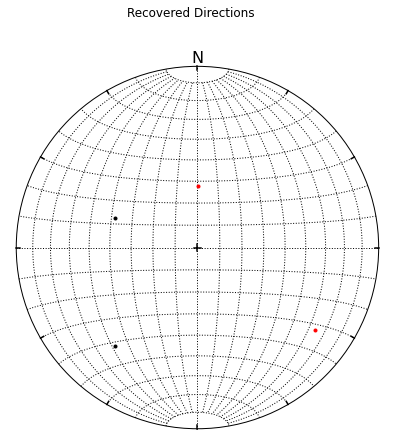

In [21]:
# Magnetic inversion using FD euler positions and magnetic data before the upward continuation

# Magnetic inversion using FD euler positions and magnetic data before the upward continuation
mx_FD_least, my_FD_least, mz_FD_least, M_FD_least, direct_model_FD_least = least_square_solver(X, Y, Z, Xc_FD, Yc_FD, Zc_FD, d)
D_FD_least, I_FD_least = directions(mx_FD_least, my_FD_least, mz_FD_least, plot=True)

#calculate momentum
momentum_FD_least = (np.sqrt(mx_FD_least**2 + my_FD_least**2 + mz_FD_least**2))


#Inversion uncertainties
# sigma_noise = (np.absolute(np.max(d))+np.absolute(np.min(d))) * error
sigma_noise = error
sigma_D_FD_least, sigma_I_FD_least, sigma_m_FD_least = uncertainties(sigma_noise, M_FD_least, mx_FD_least, my_FD_least, mz_FD_least)

import pandas as pd
df = pd.DataFrame(data={'Dec (°)': (np.round(D_FD_least, decimals=4)),
                        '$\sigma D$ (°)':    (np.round(sigma_D_FD_least, decimals=4)),
                        'Inc (°)': (np.round(I_FD_least, decimals=4)),
                        '$\sigma I$ (°)':    (np.round(sigma_I_FD_least, decimals=4)),
                        'm  ($A \cdot m^2$)':  (momentum_FD_least),
                        '$\sigma m$ ($A \cdot m^2$)':  (sigma_m_FD_least),
                        'Xc (µm)': Xc_FD*m2microm,
                        'Yc (µm)': Yc_FD*m2microm,
                        'Zc (µm)': Zc_FD*m2microm
                        
                       })

df.head(5)


,Dec (°),$\sigma D$ (°),Inc (°),$\sigma I$ (°),m ($A \cdot m^2$),$\sigma m$ ($A \cdot m^2$),Xc (µm),Yc (µm),Zc (µm)
0,-69.9408,0.1795,-50.0623,0.1027,5.410032e-15,9.142608e-18,749.988803,749.985598,5.360972
1,-140.0429,0.0996,-29.9910,0.0682,1.051211e-14,1.480421e-17,250.009134,250.002367,8.525718
2,125.0198,0.1446,22.0845,0.1012,6.229295e-15,1.404452e-17,200.016542,799.975253,7.774803
3,0.6799,0.2948,61.9668,0.1307,7.637067e-15,1.442663e-17,499.999435,500.033491,10.010794


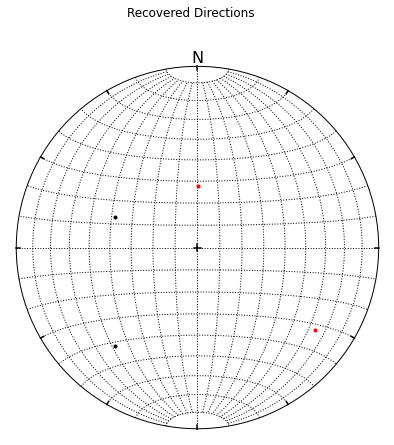

In [22]:
# Magnetic inversion using FD euler positions and magnetic data before the upward continuation

mx_FD_up_least, my_FD_up_least, mz_FD_up_least, M_FD_up_least, direct_model_FD_least = least_square_solver(X, Y, Z+delta_z, Xc_FD, Yc_FD, Zc_FD, upward)
D_FD_up_least, I_FD_up_least = directions(mx_FD_up_least, my_FD_up_least, mz_FD_up_least, plot=True)

#calculate momentum
momentum_FD_up_least = (np.sqrt(mx_FD_up_least**2 + my_FD_up_least**2 + mz_FD_up_least**2))


#Inversion uncertainties
# sigma_noise = (np.absolute(np.max(d))+np.absolute(np.min(d))) * error
sigma_noise = error
sigma_D_FD_up_least, sigma_I_FD_up_least, sigma_m_FD_up_least = uncertainties(sigma_noise, M_FD_up_least, mx_FD_up_least, my_FD_up_least, mz_FD_up_least)

import pandas as pd
df = pd.DataFrame(data={'Dec (°)': (np.round(D_FD_up_least, decimals=4)),
                        '$\sigma D$ (°)':    (np.round(sigma_D_FD_up_least, decimals=4)),
                        'Inc (°)': (np.round(I_FD_up_least, decimals=4)),
                        '$\sigma I$ (°)':    (np.round(sigma_I_FD_up_least, decimals=4)),
                        'm  ($A \cdot m^2$)':  (momentum_FD_up_least),
                        '$\sigma m$ ($A \cdot m^2$)':  (sigma_m_FD_up_least),
                        'Xc (µm)': Xc_FD*m2microm,
                        'Yc (µm)': Yc_FD*m2microm,
                        'Zc (µm)': Zc_FD*m2microm
                        
                       })

df.head(5)

# Magnetic inversion using robust method

iteration:  1
iteration:  2


,Dec (°),$\sigma D$ (°),Inc (°),$\sigma I$ (°),m ($A \cdot m^2$),$\sigma m$ ($A \cdot m^2$),Xc (µm),Yc (µm),Zc (µm)
0,-69.9690,0.0815,-50.0672,0.0466,5.422255e-15,4.159303e-18,749.988803,749.985598,5.360972
1,-140.0343,0.0530,-29.9657,0.0363,1.052434e-14,7.892289e-18,250.009134,250.002367,8.525718
2,125.0449,0.0746,22.1282,0.0522,6.239413e-15,7.253430e-18,200.016542,799.975253,7.774803
3,0.6444,0.1659,62.0086,0.0735,7.643455e-15,8.115885e-18,499.999435,500.033491,10.010794


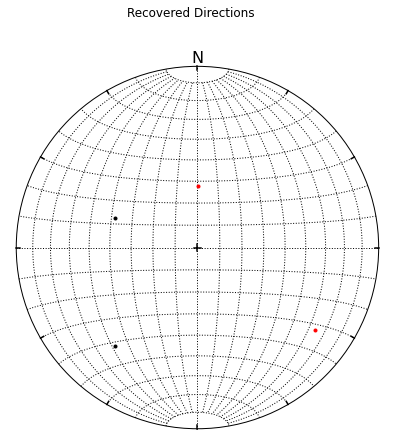

In [23]:
# Magnetic inversion using FD euler positions and magnetic data before the upward continuation

mx_FD_robust, my_FD_robust, mz_FD_robust, M_FD_robust, direct_model_FD_robust = robust_solver(X, Y, Z, Xc_FD, Yc_FD, Zc_FD, d)
D_FD_robust, I_FD_robust = directions(mx_FD_robust, my_FD_robust, mz_FD_robust, plot=True)

#calculate momentum
momentum_FD_robust = (np.sqrt(mx_FD_robust**2 + my_FD_robust**2 + mz_FD_robust**2))


#Inversion uncertainties
# sigma_noise = (np.absolute(np.max(d))+np.absolute(np.min(d))) * error
sigma_noise = error
sigma_D_FD_robust, sigma_I_FD_robust, sigma_m_FD_robust = uncertainties(sigma_noise, M_FD_robust, mx_FD_robust, my_FD_robust, mz_FD_robust)

import pandas as pd
df = pd.DataFrame(data={'Dec (°)': (np.round(D_FD_robust, decimals=4)),
                        '$\sigma D$ (°)':    (np.round(sigma_D_FD_robust, decimals=4)),
                        'Inc (°)': (np.round(I_FD_robust, decimals=4)),
                        '$\sigma I$ (°)':    (np.round(sigma_I_FD_robust, decimals=4)),
                        'm  ($A \cdot m^2$)':  (momentum_FD_robust),
                        '$\sigma m$ ($A \cdot m^2$)':  (sigma_m_FD_robust),
                        'Xc (µm)': Xc_FD*m2microm,
                        'Yc (µm)': Yc_FD*m2microm,
                        'Zc (µm)': Zc_FD*m2microm
                        
                       })

df.head(5)


iteration:  1
iteration:  2


,Dec (°),$\sigma D$ (°),Inc (°),$\sigma I$ (°),m ($A \cdot m^2$),$\sigma m$ ($A \cdot m^2$),Xc (µm),Yc (µm),Zc (µm)
0,-69.9387,0.1795,-50.0585,0.1027,5.409843e-15,9.142824e-18,749.988803,749.985598,5.360972
1,-140.0421,0.0996,-29.9889,0.0682,1.051215e-14,1.480434e-17,250.009134,250.002367,8.525718
2,125.0173,0.1446,22.0879,0.1012,6.228764e-15,1.404437e-17,200.016542,799.975253,7.774803
3,0.6810,0.2948,61.9729,0.1307,7.636569e-15,1.442611e-17,499.999435,500.033491,10.010794


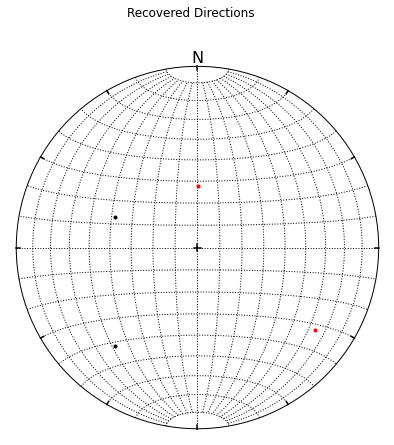

In [24]:
mx_FD_up_robust, my_FD_up_robust, mz_FD_up_robust, M_FD_up_robust, direct_model_FD_up_robust = robust_solver(X, Y, Z+delta_z, Xc_FD, Yc_FD, Zc_FD, upward)
D_FD_up_robust, I_FD_up_robust = directions(mx_FD_up_robust, my_FD_up_robust, mz_FD_up_robust, plot=True)

#calculate momentum
momentum_FD_up_robust = (np.sqrt(mx_FD_up_robust**2 + my_FD_up_robust**2 + mz_FD_up_robust**2))


#Inversion uncertainties
# sigma_noise = (np.absolute(np.max(d))+np.absolute(np.min(d))) * error
sigma_noise = error
sigma_D_FD_up_robust, sigma_I_FD_up_robust, sigma_m_FD_up_robust = uncertainties(sigma_noise, M_FD_up_robust, mx_FD_up_robust, my_FD_up_robust, mz_FD_up_robust)

import pandas as pd
df = pd.DataFrame(data={'Dec (°)': (np.round(D_FD_up_robust, decimals=4)),
                        '$\sigma D$ (°)':    (np.round(sigma_D_FD_up_robust, decimals=4)),
                        'Inc (°)': (np.round(I_FD_up_robust, decimals=4)),
                        '$\sigma I$ (°)':    (np.round(sigma_I_FD_up_robust, decimals=4)),
                        'm  ($A \cdot m^2$)':  (momentum_FD_up_robust),
                        '$\sigma m$ ($A \cdot m^2$)':  (sigma_m_FD_up_robust),
                        'Xc (µm)': Xc_FD*m2microm,
                        'Yc (µm)': Yc_FD*m2microm,
                        'Zc (µm)': Zc_FD*m2microm
                        
                       })

df.head(5)

# Article Figure

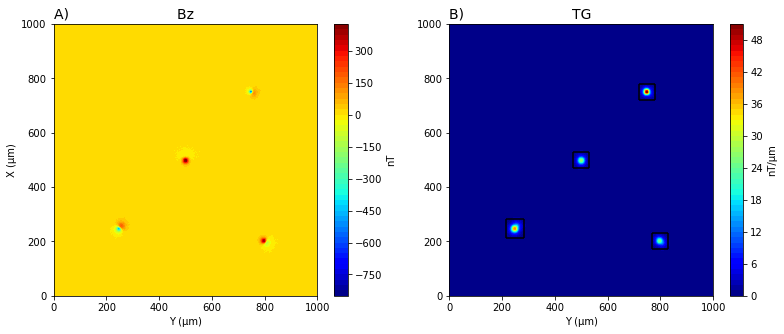

In [40]:
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(13,5))

# plot FD horizontal gradient 
ax1_plot  = ax1.contourf(x_plot, y_plot, d_*10**9, levels=50, cmap='jet')
plt.colorbar(ax1_plot, ax=ax1, label='nT')
ax1.set_title('A)                        Bz', fontsize=14, loc='left')
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

# plot FFT horizontal gradient 
ax2_plot = ax2.contourf(x_plot, y_plot, Total_Grad_FD*1.0e3, levels=50, cmap='jet')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title('B)                        TG', fontsize=14, loc='left')
ax2.set_xlabel('Y (µm)', fontsize=10)
#ax2.set_ylabel('X (µm)', fontsize=10)

# plot isolated windows 
nx, ny = np.shape(d_)
y_step = (np.max(Y_)*m2microm - np.min(Y_)*m2microm) / (ny-1)
x_step = (np.max(X_)*m2microm - np.min(X_)*m2microm) / (nx-1)
color='k'
for i in range(np.shape(euler_windows_FD)[0]):
    x1 = int(euler_windows_FD[i,0]) * x_step
    x2 = int(euler_windows_FD[i,1]) * x_step
    y1 = int(euler_windows_FD[i,2]) * y_step
    y2 = int(euler_windows_FD[i,3]) * y_step

    plt.hlines(x1, y1, y2, color=color)
    plt.hlines(x2, y1, y2, color=color)
    plt.vlines(y1, x1, x2, color=color)
    plt.vlines(y2, x1, x2, color=color)


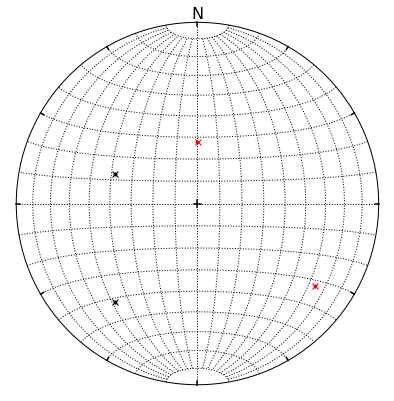

In [26]:
s = StereoNet(grid=True, legend=True)
settings['figsize'] = (7, 7)

for w in range (np.size(D)):
    if I[w] >= 0:
        symbol = '.'
        color = 'r'
    else:
        symbol = '.'
        color = 'k'

    if w == 0:
        s.line((Lin(float(D[w]), np.round(np.absolute(I[w])))), color=color, marker=symbol)
        #group.append((Lin(float(D[w]), np.round(np.absolute(I[w])))))
    else:
        s.line((Lin(float(D[w]), np.round(np.absolute(I[w])))), color=color, marker=symbol)
        #group.append((Lin(float(D[w]), np.round(np.absolute(I[w])))))
        
        
for k in range (np.size(D_FD_least)):
    if I_FD_least[k] >= 0:
        symbol = 'x'
        color = 'r'
    else:
        symbol = 'x'
        color = 'k'

    if k == 0:
        s.line((Lin(float(D_FD_least[k]), np.round(np.absolute(I_FD_least[k])))), color=color, marker=symbol)
        #group.append((Lin(float(D_FD_least[k]), np.round(np.absolute(I_FD_least[k])))))
    else:
        s.line((Lin(float(D_FD_least[k]), np.round(np.absolute(I_FD_least[k])))), color=color, marker=symbol)
        #group.append((Lin(float(D_FD_least[k]), np.round(np.absolute(I_FD_least[k])))))



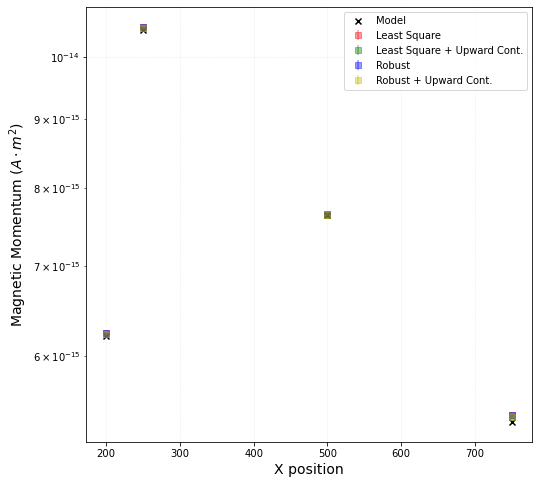

In [27]:
sources = np.copy(Xc_FD*m2microm)

real=(np.array(Q)*4/3*np.pi*np.array(R)**3)

plt.figure(figsize=(8,8))
plt.errorbar(sources, momentum_FD_least, sigma_m_FD_least, fmt='s', alpha=0.4, color='r', label='Least Square')
plt.errorbar(sources, momentum_FD_up_least, sigma_m_FD_up_least, fmt='s', alpha=0.4, color='g', label='Least Square + Upward Cont.')
plt.errorbar(sources, momentum_FD_robust, sigma_m_FD_robust, fmt='s', alpha=0.4, color='b', label='Robust')
plt.errorbar(sources, momentum_FD_up_robust, sigma_m_FD_up_robust, fmt='s', alpha=0.4, color='y', label='Robust + Upward Cont.' )

plt.scatter(np.array(Xc*m2microm), real, marker='x', color='k', label='Model')

plt.legend()
plt.grid(alpha=0.3, linestyle=':')

plt.xlabel('X position', fontsize=14);
plt.ylabel('Magnetic Momentum ($A \cdot m^2$)', fontsize=14);

plt.yscale('log')


In [33]:
def cone(Dec0, Inc0, delta_Dec, delta_Inc, size=200):

    Dec = np.arange(-180, 180, 0.5)
    Inc = np.arange(-90, 90, 0.5)
    
    Dec_acum = []
    Inc_acum = []
    group = []
    
    
    dec_member = (Dec - Dec0)**2/(delta_Dec)**2
    inc_member = (Inc - Inc0)**2/(delta_Inc)**2
    
    for i in range(len(Dec)):
        for j in range(len(Inc)):
            if np.round(dec_member[i]+inc_member[j], decimals=1) <= 1.0:
                group.append(Lin(Dec[i], (Inc[j])))
    group = Group(group)
    

    return(group)

In [34]:
# settings['figsize'] = (7, 7)
# s = StereoNet(grid=True, legend=True)

# for i in range(np.size(D_FD_least)):
#     group = cone(D_FD_least[i], np.absolute(I_FD_least[i]), sigma_D_FD_least[i], sigma_I_FD_least[i])
    
    
#     if I_FD_least[i] >= 0:
#         symbol = '.'
#         color = 'r'
#     else:
#         symbol = '.'
#         color = 'k'

#     s.line(group, color=color, marker=symbol, alpha=0.01)
#     s.line(Lin(D_FD_least[i], np.absolute(I_FD_least[i])), color=color, marker=symbol)
    
    
# for w in range (np.size(D)):
#     if I[w] >= 0:
#         symbol = 'x'
#         color = 'r'
#     else:
#         symbol = 'x'
#         color = 'k'

#     s.line((Lin(float(D[w]), np.round(np.absolute(I[w])))), color=color, marker=symbol)


In [35]:
# settings['figsize'] = (7, 7)
# s = StereoNet(grid=True, legend=True)

# for i in range(np.size(D_FD_least)):
#     group = cone(D_FD_up_least[i], np.absolute(I_FD_up_least[i]), sigma_D_FD_up_least[i], sigma_I_FD_up_least[i])
    
    
#     if I_FD_up_least[i] >= 0:
#         symbol = '.'
#         color = 'r'
#     else:
#         symbol = '.'
#         color = 'k'

#     s.line(group, color=color, marker=symbol, alpha=0.01)
#     s.line(Lin(D_FD_up_least[i], np.absolute(I_FD_up_least[i])), color=color, marker=symbol)
    
    
# for w in range (np.size(D)):
#     if I[w] >= 0:
#         symbol = 'x'
#         color = 'r'
#     else:
#         symbol = 'x'
#         color = 'k'

#     s.line((Lin(float(D[w]), np.round(np.absolute(I[w])))), color=color, marker=symbol)

In [36]:
# settings['figsize'] = (7, 7)
# s = StereoNet(grid=True, legend=True)

# for i in range(np.size(D_FD_least)):
#     group = cone(D_FD_robust[i], np.absolute(I_FD_robust[i]), sigma_D_FD_robust[i], sigma_I_FD_robust[i])
    
    
#     if I_FD_robust[i] >= 0:
#         symbol = '.'
#         color = 'r'
#     else:
#         symbol = '.'
#         color = 'k'

#     s.line(group, color=color, marker=symbol, alpha=0.01)
#     s.line(Lin(D_FD_robust[i], np.absolute(I_FD_robust[i])), color=color, marker=symbol)
    
    
# for w in range (np.size(D)):
#     if I[w] >= 0:
#         symbol = 'x'
#         color = 'r'
#     else:
#         symbol = 'x'
#         color = 'k'

#     s.line((Lin(float(D[w]), np.round(np.absolute(I[w])))), color=color, marker=symbol)

In [37]:
# settings['figsize'] = (7, 7)
# s = StereoNet(grid=True, legend=True)

# for i in range(np.size(D_FD_least)):
#     group = cone(D_FD_up_robust[i], np.absolute(I_FD_up_robust[i]), sigma_D_FD_up_robust[i], sigma_I_FD_up_robust[i])
    
    
#     if I_FD_up_robust[i] >= 0:
#         symbol = '.'
#         color = 'r'
#     else:
#         symbol = '.'
#         color = 'k'

#     s.line(group, color=color, marker=symbol, alpha=0.01)
#     s.line(Lin(D_FD_up_robust[i], np.absolute(I_FD_up_robust[i])), color=color, marker=symbol)
    
    
# for w in range (np.size(D)):
#     if I[w] >= 0:
#         symbol = 'x'
#         color = 'r'
#     else:
#         symbol = 'x'
#         color = 'k'

#     s.line((Lin(float(D[w]), np.round(np.absolute(I[w])))), color=color, marker=symbol)

In [38]:
print(sources)
print(real)

[749.98880298 250.00913397 200.01654165 499.99943518]
[1.04719755e-14 7.63407015e-15 5.36165146e-15 6.20678177e-15]
